In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import ndimage
import glob

plt.rcParams['figure.dpi'] = 200

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [24]:
##maybe create mask using pixel values that are not 0
fn = glob.glob("outimg\distance\*.png")

In [46]:
img = plt.imread('outimg\\distance\\07_distance_77_-55_-29_20.png')

In [8]:
fn = glob.glob("outimg\distance\*.npy")
fn2 = glob.glob("outimg\label\*.npy")

In [9]:
img=[]
label=[]
for f in fn:
    ar = np.load(f)
    #ar = plt.imread(f)
    img.append(ar)
for f in fn2:
    ar = np.load(f)
    label.append(ar)



In [10]:
label = np.array(label, dtype="int")
train = np.array(img)
label = np.expand_dims(label, axis=-1)
train = np.expand_dims(train, axis=-1)
print(label.shape)
print(train.shape)

(1484, 512, 512, 1)
(1484, 512, 512, 1)


In [15]:
def sc255(arr):
    return ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
train=np.apply_along_axis(sc255,0,train)

In [33]:
np.unique(train[100])

array([  0, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       253, 254, 255], dtype=uint8)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    train, label, test_size=0.2
)

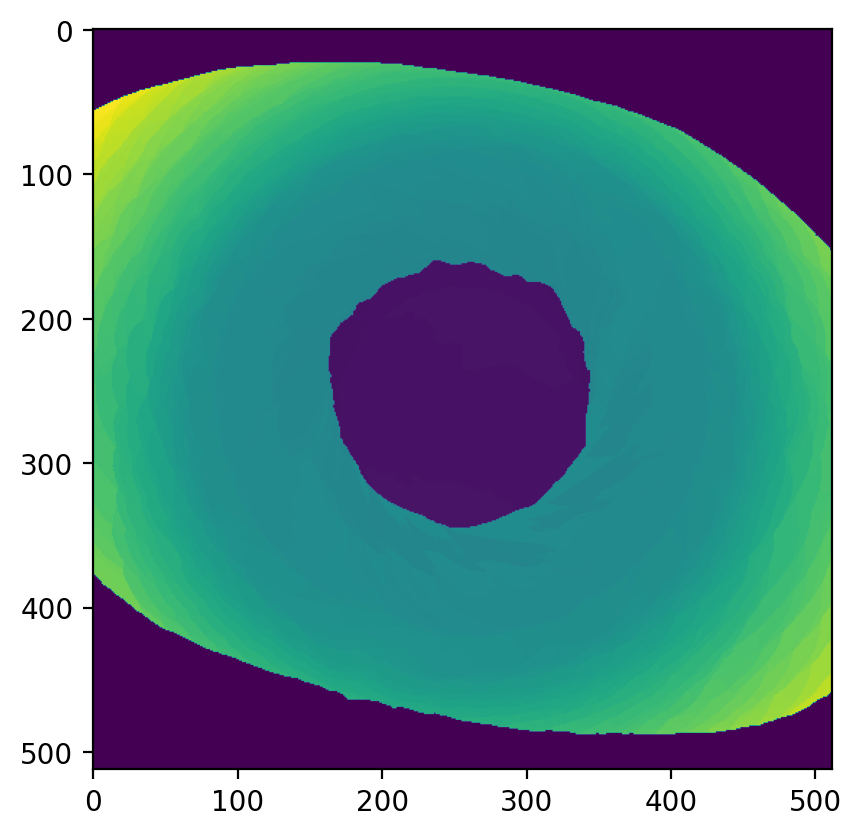

In [30]:
plt.imshow(train[1400])

In [7]:
fp = np.memmap('outimg\depths.npy', dtype='float32', mode='w+', shape=(26160, 1024, 1024))

In [8]:
fp[:] = img[:]

In [ ]:
fp

In [4]:
depth = np.memmap('outimg\depths.npy', dtype='float32', mode='r', shape=(26160, 1024, 1024))

In [6]:
Label = np.memmap('outimg\labels.npy', dtype='float32', mode='w+', shape=(26160, 1024, 1024))

In [8]:
def writelabel(i):
    Label[i]=(~np.isinf(depth[i])).astype(int)
for i in range(depth.shape[0]):
    writelabel(i)

In [9]:
Label.flush()

In [72]:
Label = np.memmap('outimg\labels.npy', dtype='float32', mode='r', shape=(26160, 1024, 1024))

In [34]:
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        input
    )
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

In [14]:
depth = np.expand_dims(depth, -1)

In [16]:
Label = np.expand_dims(Label, -1)

In [17]:
print(depth.shape)
print(Label.shape)

(26160, 1024, 1024, 1)
(26160, 1024, 1024, 1)


In [27]:
ind = np.arange(depth.shape[0])
np.random.shuffle(ind)

In [36]:
ratio=int(depth.shape[0]*0.8)
#depth = depth[ind]
#Label = Label[ind]
x_train, x_test, y_train, y_test = depth[:ratio], depth[ratio:], Label[:ratio], Label[ratio:]

In [35]:
input_shape = x_train.shape[1:]
batch_size = 32
learning_rate = 0.1
epochs = 100

model = build_unet(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)],
)

In [36]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['batch_normalization[0][0

In [9]:
def load_data(image_filepaths, batch_size):
    num_samples = len(image_filepaths)
    dataset = tf.data.Dataset.from_tensor_slices((image_filepaths, image_filepaths))

    def load_and_preprocess_image(image_path):
        image = np.load(image_path)
        label = (~np.isinf(image)).astype(int)
        image[np.isinf(image)] = 0
        image[np.isnan(image)] = 0
        return image, label

    dataset = dataset.map(lambda x,y: tf.numpy_function(load_and_preprocess_image, [x,y], [tf.float32,tf.int32]))
    dataset = dataset.batch(batch_size)
    return dataset

In [89]:
data = load_data(fn, 64)

In [37]:
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
)

Epoch 1/100


: 

: 

In [91]:
history = model.fit(
    depth[:200],
    Label[:200],
    #data,
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/10


TypeError: in user code:

    File "c:\Users\vitoc\miniconda3\envs\ML\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\vitoc\miniconda3\envs\ML\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\vitoc\miniconda3\envs\ML\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\vitoc\miniconda3\envs\ML\Lib\site-packages\keras\src\engine\training.py", line 1085, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\vitoc\miniconda3\envs\ML\Lib\site-packages\keras\src\engine\training.py", line 1179, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\vitoc\miniconda3\envs\ML\Lib\site-packages\keras\src\engine\compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\vitoc\miniconda3\envs\ML\Lib\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\vitoc\miniconda3\envs\ML\Lib\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "c:\Users\vitoc\miniconda3\envs\ML\Lib\site-packages\keras\src\metrics\iou_metrics.py", line 417, in update_state  **
        return super().update_state(y_true, y_pred, sample_weight)
    File "c:\Users\vitoc\miniconda3\envs\ML\Lib\site-packages\keras\src\metrics\iou_metrics.py", line 123, in update_state
        if y_true.shape.ndims > 1:

    TypeError: '>' not supported between instances of 'NoneType' and 'int'


In [42]:
def learning_progress(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)
    #tree_iou = history.history["binary_io_u"]
    #val_tree_iou = history.history["val_binary_io_u"]
    fg, ax = pl.subplots(1, 2, figsize=(10, 5))
    ax[0].semilogy(epochs, loss, "y", label="Training loss")
    ax[0].plot(epochs, val_loss, "r", label="Validation loss")
    ax[0].set_title("Training and validation loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].grid()
    ax[0].legend()
    #ax[1].plot(epochs, tree_iou, "y", label="Training IoU")
    #ax[1].plot(epochs, val_tree_iou, "r", label="Validation IoU")
    ax[1].set_title("Training and validation tree IoU")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("IoU for trees")
    ax[1].set_ylim((-0.01, 1.01))
    ax[1].grid()
    ax[1].legend()
    pl.show()

In [43]:
learning_progress(history)

NameError: name 'history' is not defined

In [ ]:
model.save(
    "unet-px%i-bs%i-lr%0.3f-ep%i.hdf5"
    % (input_shape[0], batch_size, learning_rate, epochs)
)

In [ ]:
# load model
model = tf.keras.models.load_model(
    "unet-aug-px128-bs32-lr0.001-ep50.hdf5", compile=False
)

In [ ]:
# predict tree probabilities for all test images
y_pred = model.predict(x_test)
print(y_pred.shape)

# Convert sigmoid probability to classification
y_pred_thresholded = y_pred > 0.5

In [ ]:
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_pred=y_pred_thresholded, y_true=y_test)

biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)

print("Mean IoU =", miou.result().numpy())
print("Binary IoU =", biou.result().numpy())

# only for trees
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 1 =", biou.result().numpy())

# only for non-tree pixel
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 0 =", biou.result().numpy())

In [ ]:
def prediction_testing(model, k, threshold=0.5):
    test_img = x_test[k]
    ground_truth = y_test[k][:, :, 0]
    prediction = model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]
    fg, ax = pl.subplots(1, 3, figsize=(17, 5))
    ax[0].set_title("Predicted label on RGB input")
    ax[0].imshow(prediction > 0.5, cmap="magma_r")
    ax[0].imshow(test_img[:, :, :3], alpha=0.8)
    ax[1].set_title("Labels")
    ax[1].imshow(prediction > 0.5, cmap="magma_r")
    ax[1].imshow(ground_truth, cmap="Greens", alpha=0.8)
    ax[2].set_title("Prediction on test image")
    im = ax[2].imshow(prediction, vmin=0, vmax=1, cmap="magma_r")
    cb = fg.colorbar(im, ax=ax, shrink=0.8)
    cb.set_label("Tree probability")
    pl.show()

In [ ]:
prediction_testing(model, np.random.randint(0, len(x_test) - 1))